In [19]:
using FileIO
using CSV
using DataFrames
using Statistics
using StatsPlots, Interact
using Blink



### Repetition of visualiying comment annoations,

In [20]:
cmt_info_df = CSV.read(joinpath("S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\annotated", "r_cmt_stratified_annotated.csv"), DataFrame)

GPT4_inst_labels = ["A", "B", "C", "D", "E", "F", "G", "H"]
dirpath = "S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\annotated"
filename = "annot_full.csv"

df = CSV.read(joinpath(dirpath, filename), DataFrame)
#df = df[1:123, 1:end]
#Drop irrelevant columns:
#select!(df, Not([Symbol("batch_#"),Symbol("cmt_#_in_Batch"), Symbol("engagement_human"), Symbol("sentiment_human"), Symbol("engagement_human_final"),  Symbol("sentiment_human_final"),  Symbol("selected_for_check"),  Symbol("engagement_maj_agreement"),  Symbol("sentiment_maj_agreement"),  Symbol("engagement_final_maj_agreement"),  Symbol("sentiment_final_maj_agreement")]))	
select!(df, Not([Symbol("batch_#"),Symbol("cmt_#_in_Batch"), Symbol("engagement_human"), Symbol("sentiment_human"), Symbol("selected_for_check"),  Symbol("engagement_maj_agreement"),  Symbol("sentiment_maj_agreement")]))	

#Print header (column names and column data types) of the dataframe
@show names(df)
@show eltype.(eachcol(df))

#Change annotation columns to integers
for inst_label in GPT4_inst_labels
    if eltype(df[!,Symbol("engagement_GPT4_"*inst_label)]) .!= Int64
        df[!,Symbol("engagement_GPT4_"*inst_label)] =  convert.(Union{Int64, Missing}, df[!,Symbol("engagement_GPT4_"*inst_label)])
    end
    if eltype(df[!,Symbol("sentiment_GPT4_"*inst_label)]) .!= Int64
        df[!,Symbol("sentiment_GPT4_"*inst_label)] = convert.(Union{Int64, Missing}, df[!,Symbol("sentiment_GPT4_"*inst_label)])
    end
end

#Sort dataframe by article ID
sort!(df, :article_id)

names(df) = ["cmt_id", "comment_body", "engagement_GPT4_A", "engagement_GPT4_B", "engagement_GPT4_C", "engagement_GPT4_D", "engagement_GPT4_E", "engagement_GPT4_F", "engagement_GPT4_G", "engagement_GPT4_H", "sentiment_GPT4_A", "sentiment_GPT4_B", "sentiment_GPT4_C", "sentiment_GPT4_D", "sentiment_GPT4_E", "sentiment_GPT4_F", "sentiment_GPT4_G", "sentiment_GPT4_H", "engagement_GPT4_majority", "sentiment_GPT4_majority", "article_id", "article_headline"]
eltype.(eachcol(df)) = Union[Union{Missing, String7}, Union{Missing, String}, Union{Missing, Int64}, Union{Missing, Int64}, Union{Missing, Float64}, Union{Missing, Float64}, Union{Missing, Int64}, Union{Missing, Int64}, Union{Missing, Int64}, Union{Missing, Int64}, Union{Missing, Int64}, Union{Missing, Int64}, Union{Missing, Float64}, Union{Missing, Float64}, Union{Missing, Int64}, Union{Missing, Int64}, Union{Missing, Int64}, Union{Missing, Int64}, Union{Missing, Int64}, Union{Missing, Int64}, Union{Missing, String}, Union{Missing, Strin

Row,cmt_id,comment_body,engagement_GPT4_A,engagement_GPT4_B,engagement_GPT4_C,engagement_GPT4_D,engagement_GPT4_E,engagement_GPT4_F,engagement_GPT4_G,engagement_GPT4_H,sentiment_GPT4_A,sentiment_GPT4_B,sentiment_GPT4_C,sentiment_GPT4_D,sentiment_GPT4_E,sentiment_GPT4_F,sentiment_GPT4_G,sentiment_GPT4_H,engagement_GPT4_majority,sentiment_GPT4_majority,article_id,article_headline
,String7?,String?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,String?,String?
1,cxsj14d,"I need to save this picture, so in 20 years, I can compare it to my phone and everyone will be amazed how big quantum computers used to be.",0,0,0,0,0,0,0,0,2,2,1,1,2,2,2,2,0,2,02dcb8cb079fe6bf93b3855762205be5be8f5b48d9f3cd25ad5c30a4c369799b,Google says its quantum computer is more than 100 million times faster than a regular computer chip
2,cxsjrrf,"Misleading title. It's not a quantum computer that Google built, it is a D-Wave.",1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,0,02dcb8cb079fe6bf93b3855762205be5be8f5b48d9f3cd25ad5c30a4c369799b,Google says its quantum computer is more than 100 million times faster than a regular computer chip
3,cxsktqg,Oh I can't wait until this becomes the minimum requirement to run Openoffice!,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,0,2,02dcb8cb079fe6bf93b3855762205be5be8f5b48d9f3cd25ad5c30a4c369799b,Google says its quantum computer is more than 100 million times faster than a regular computer chip
4,cxsqlgl,"I can already feel the snide posts coming from future reddit. ""This is what a quantum computer, used for basic arithmetic calculations, looked like in 2015.""",0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,02dcb8cb079fe6bf93b3855762205be5be8f5b48d9f3cd25ad5c30a4c369799b,Google says its quantum computer is more than 100 million times faster than a regular computer chip
5,cxsqp5a,Now I wanna know.. Will it blend?,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,02dcb8cb079fe6bf93b3855762205be5be8f5b48d9f3cd25ad5c30a4c369799b,Google says its quantum computer is more than 100 million times faster than a regular computer chip
6,cxsslsy,I don't believe google. If they let me borrow it ill decide for my self.,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,-9,0,02dcb8cb079fe6bf93b3855762205be5be8f5b48d9f3cd25ad5c30a4c369799b,Google says its quantum computer is more than 100 million times faster than a regular computer chip
7,cxsxxe8,Bet that thing can run one hell of a dwarf fortress game.,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,0,2,02dcb8cb079fe6bf93b3855762205be5be8f5b48d9f3cd25ad5c30a4c369799b,Google says its quantum computer is more than 100 million times faster than a regular computer chip
8,cxta5y0,"I remember reading an article a little over a decade ago that when we first started using quantum computing, there was a small chance that we could somehow link up with other quantum computers in the universe because of the way quantum physics was thought to work. It was all way above my head, but is that complete nonsense or could Google suddenly be sharing computational power with E.T.?",1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,02dcb8cb079fe6bf93b3855762205be5be8f5b48d9f3cd25ad5c30a4c369799b,Google says its quantum computer is more than 100 million times faster than a regular computer chip
9,cxtden4,Wait...weve moved beyond factoring 15? Why didnt i get the memo?,0,0,1,1,0,0,0,0,1,1,1,1,1,1,1,1,0,1,02dcb8cb079fe6bf93b3855762205be5be8f5b48d9f3cd25ad5c30a4c369799b,Google says its quantum computer is more than 100 million times faster than a regular computer chip


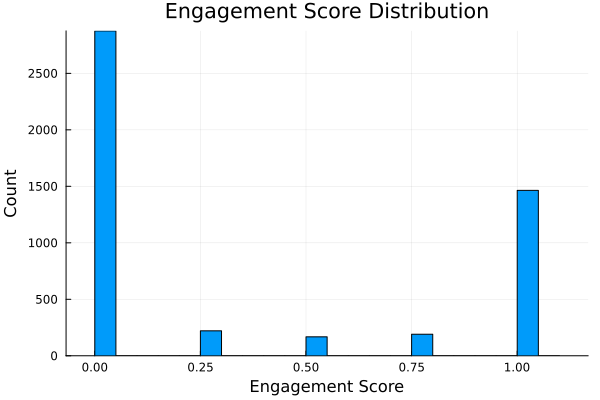

In [21]:
# Add a score column to the dataframe

df[!, :engagement_score] = zeros(Float64, size(df,1))
for inst_label in GPT4_inst_labels
    df[!, :engagement_score] .+= (df[!, Symbol("engagement_GPT4_$inst_label")] ./ 8)
end

df[!, :sentiment_score] = zeros(Float64, size(df,1))
for inst_label in GPT4_inst_labels
    df[!, :sentiment_score] .+= (df[!, Symbol("sentiment_GPT4_$inst_label")] ./ (8*2))
end

# Plot score distribution as histogram
@df df histogram(:engagement_score, bins=0.0:0.05:1.1, xlabel="Engagement Score", ylabel="Count", title="Engagement Score Distribution", legend=false)

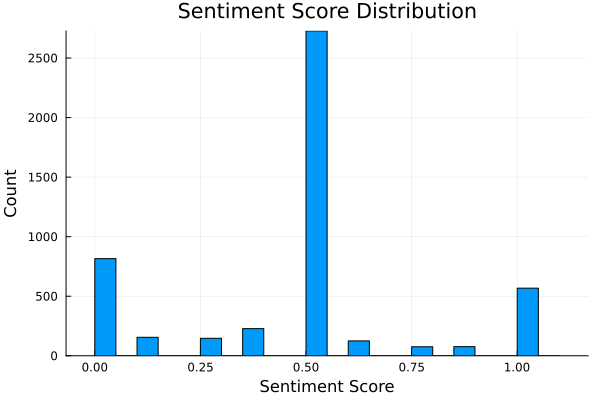

In [22]:
@df df histogram(:sentiment_score, bins=0.0:0.05:1.1, xlabel="Sentiment Score", ylabel="Count", title="Sentiment Score Distribution", legend=false)

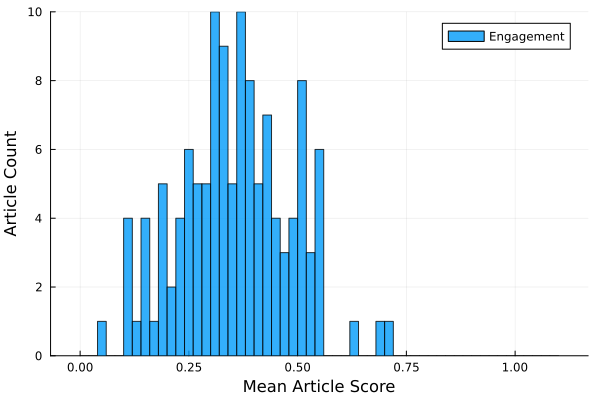

In [23]:
# For each unique article id, calculate the mean and std of engagement score per article
df_mean_scores = combine(groupby(df, :article_id), :engagement_score => mean, :sentiment_score => mean)
df_std_scores = combine(groupby(df, :article_id), :engagement_score => std, :sentiment_score => std)

dropmissing!(df_mean_scores, :article_id)
dropmissing!(df_std_scores, :article_id)

@assert size(df_mean_scores,1) == 123
@assert size(df_std_scores,1) == 123

# Plot mean score distribution as histogram
plt = @df df_mean_scores histogram(:engagement_score_mean, bins=0.0:0.02:1.1, xlabel="Mean Article Score", ylabel="Article Count", legend=true, label="Engagement", alpha=0.8)
#@df df_mean_scores histogram!(:sentiment_score_mean, bins=0.0:0.02:1.1, label="Sentiment", alpha=0.5)
#savefig(plt, "./output_and_results/mean_art_score_engagement.png")

#Mean of mean of histograms:
#@show median(df_mean_scores[!, :sentiment_score_mean])

# Complete figure description:
# Figure X: Distribution of mean article scores for (a) engagement and (b) sentiment

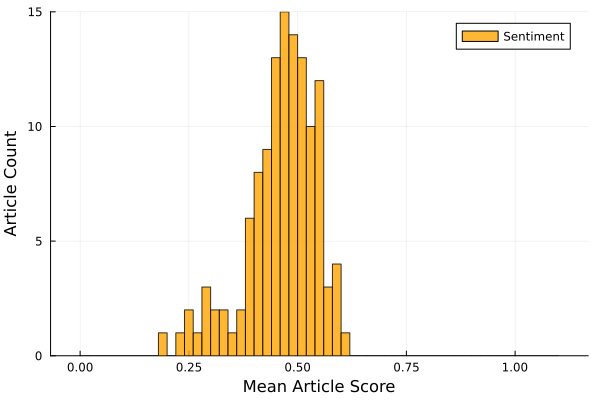

In [24]:
# Plot mean score distribution as histogram

plt = @df df_mean_scores histogram(:sentiment_score_mean, bins=0.0:0.02:1.1, xlabel="Mean Article Score", ylabel="Article Count", legend=true, label="Sentiment", color=:orange, alpha=0.8)
#savefig(plt, "./output_and_results/mean_art_score_sentiment.png")
#@df df_mean_scores histogram!(:engagement_score_mean, bins=0.0:0.02:1.1, label="Engagement", alpha=0.3, color=:blue)


In [37]:
grouped_df = groupby(df, :article_id)

art_id_keys = keys(grouped_df)[1:end-1]

#engagement_score_data = Array{Float64}(undef, (40, 0))
#sentiment_score_data = Array{Float64}(undef, (40, 0))
first_engagement_scores = Array{Float64}(undef, (1,0))
first_sentiment_scores = Array{Float64}(undef, (1,0))

for art_id_key in art_id_keys
    #engagement_score_data = cat(engagement_score_data, reshape(grouped_df[art_id_key][!, :engagement_score], :, 1), dims=2)
    #sentiment_score_data = cat(sentiment_score_data, reshape(grouped_df[art_id_key][!, :sentiment_score], :, 1), dims=2)
    
    art_cmt_ids = grouped_df[art_id_key][!, :cmt_id]
    art_cmt_rows = filter(:comment_id => id -> id in art_cmt_ids, cmt_info_df)
    #cmt_info_df[cmt_info_df[!, :comment_id] in art_cmt_ids, [:comment_id, :date, :engagement_score, :sentiment_score]]
    #Get the rows with the lowest date
    #first_cmt_row = art_cmt_rows[findmin(art_cmt_rows[!, :date])[2], :]
    #first_engagement_scores = cat(first_engagement_scores, [first_cmt_row[:engagement_score],], dims=2)
    #first_sentiment_scores = cat(first_sentiment_scores, [first_cmt_row[:sentiment_score],], dims=2)

    #Get the k rows with the k lowest dates
    k=2
    first_cmt_rows = art_cmt_rows[sortperm(art_cmt_rows[!, :date])[1:k], :]
    #Store now the mean of the k rows
    first_engagement_scores = cat(first_engagement_scores, [mean(first_cmt_rows[!, :engagement_score]),], dims=2)
    first_sentiment_scores = cat(first_sentiment_scores, [mean(first_cmt_rows[!, :sentiment_score]),], dims=2)    

end

@show size(engagement_score_data)


size(engagement_score_data) = (40, 123)

(40, 123)

### new: healdine annotations

In [26]:
art_mean_scores_df = df

_ = " "

" "

names(annotated_headlines_df) = ["article_id", "headline", "sentiment_Human_final", "sentiment_GPT4_A", "sentiment_GPT4_B", "sentiment_GPT4_C", "sentiment_GPT4_D", "sentiment_GPT4_E", "sentiment_GPT4_F", "sentiment_GPT4_G", "sentiment_GPT4_H", "sentiment_GPT4_Majority", "sentiment_GPT4_score"]
eltype.(eachcol(annotated_headlines_df)) = DataType[String, String, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, String1, String7]

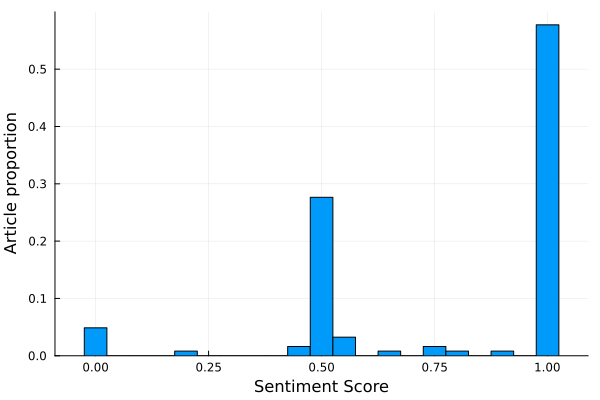

In [27]:
GPT4_inst_labels = ["A", "B", "C", "D", "E", "F", "G", "H"]
dirpath = "S:\\Sync\\University\\2023_MRP_1\\MRP1_WorkDir\\data\\annotated"
filename = "r_headlines_stratified_annotated.csv"

annotated_headlines_df = CSV.read(joinpath(dirpath, filename), DataFrame)

#Print header (column names and column data types) of the dataframe
@show names(annotated_headlines_df)
@show eltype.(eachcol(annotated_headlines_df))

#Change annotation columns to integers
for inst_label in GPT4_inst_labels
    if eltype(annotated_headlines_df[!,Symbol("sentiment_GPT4_"*inst_label)]) .!= Int64
        annotated_headlines_df[!,Symbol("sentiment_GPT4_"*inst_label)] = convert.(Union{Int64, Missing}, annotated_headlines_df[!,Symbol("sentiment_GPT4_"*inst_label)])
    end
end


# Add a score column to the dataframe
annotated_headlines_df[!, :headline_sentiment_score] = zeros(Float64, size(annotated_headlines_df,1))
for inst_label in GPT4_inst_labels
    annotated_headlines_df[!, :headline_sentiment_score] .+= (annotated_headlines_df[!, Symbol("sentiment_GPT4_$inst_label")] ./ (8*2))
end
annotated_headlines_df[!, :sentiment_Human_final] = annotated_headlines_df[!, :sentiment_Human_final] ./ 2

# Sort dataframe by article ID
sort!(annotated_headlines_df, :article_id)

# Plot score distribution as histogram
@df annotated_headlines_df histogram(:headline_sentiment_score, bins=0.0-0.025:0.05:1.025, xlabel="Sentiment Score", ylabel="Article proportion",  legend=false, normalize=:probability)
ylims!((0,0.6))

h = Histogram{Int64, 1, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}
edges:
  -0.025:0.05:1.025
weights: [6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 64, 0, 0, 0, 0, 0, 0, 0, 0, 0, 53]
closed: left
isdensity: false
h = Histogram{Int64, 1, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}
edges:
  -0.025:0.05:1.025
weights: [6, 0, 0, 0, 1, 0, 0, 0, 0, 2, 34, 4, 0, 1, 0, 2, 1, 0, 1, 0, 71]
closed: left
isdensity: false

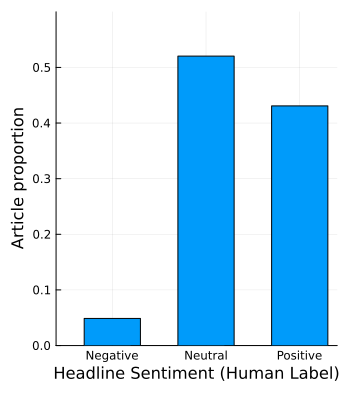

In [28]:
using StatsBase

# Plot score distribution as histogram
h = fit(Histogram, annotated_headlines_df.sentiment_Human_final, 0.0-0.025:0.05:1.025)
@show h
h = fit(Histogram, annotated_headlines_df.headline_sentiment_score, 0.0-0.025:0.05:1.025)
@show h


@df annotated_headlines_df histogram(:sentiment_Human_final, bins=0.0-0.125:0.25:1.125,  xlabel="Headline Sentiment (Human Label)", ylabel="Article proportion", legend=false, size=(350,400), bar_width=0.3, normalize=:probability)
xticks!([0.0, 0.5, 1.0], ["Negative", "Neutral", "Positive"]) 
xlims!(-0.3, 1.2)
ylims!(0, 0.6)

In [29]:
#scatter(annotated_headlines_df[!, :sentiment_Human_final], annotated_headlines_df[!, :headline_sentiment_score],)

In [30]:
# merge the score column of annotated_headlines_df into  annotated_cmt_df

@show names(annotated_headlines_df)
@show  names(df_mean_scores)
joined_df = innerjoin(df_mean_scores, annotated_headlines_df, on=:article_id)

#Rename the columns
rename!(joined_df, :sentiment_Human_final => :headline_sentiment_human)

_ = " "

names(annotated_headlines_df) = ["article_id", "headline", "sentiment_Human_final", "sentiment_GPT4_A", "sentiment_GPT4_B", "sentiment_GPT4_C", "sentiment_GPT4_D", "sentiment_GPT4_E", "sentiment_GPT4_F", "sentiment_GPT4_G", "sentiment_GPT4_H", "sentiment_GPT4_Majority", "sentiment_GPT4_score", "headline_sentiment_score"]
names(df_mean_scores) = ["article_id", "engagement_score_mean", "sentiment_score_mean"]


" "

In [31]:
hss, ssm, esm, hsh = [], [], [], []

for art_id in joined_df[!, :article_id]
    art_info = joined_df[joined_df[!, :article_id] .== art_id, :]
    append!(hss, art_info[!, :headline_sentiment_score])
    append!(ssm, art_info[!, :sentiment_score_mean])
    append!(esm, art_info[!, :engagement_score_mean])
    append!(hsh, art_info[!, :headline_sentiment_human])
end


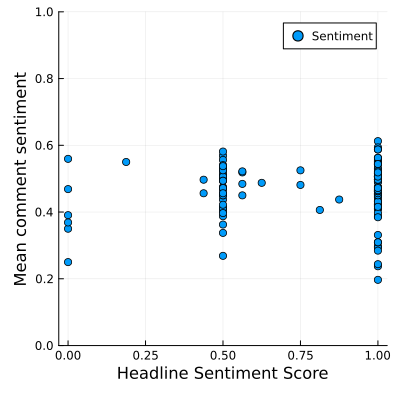

In [32]:

size(joined_df)

scatter(joined_df[!, :headline_sentiment_score], joined_df[!, :sentiment_score_mean],
    xlabel="Headline Sentiment Score", ylabel="Mean comment sentiment",
    #title="Headline Sentiment Score vs. Mean Comment Sentiment",#
    #color=:blue, 
    label="Sentiment",
    size=(400, 400),
    legend=true)

#scatter!(hss, ssm,)
ylims!(0.0, 1.0)


In [33]:
@show mean(joined_df[!, :sentiment_score_mean])

mean(joined_df[!, :sentiment_score_mean]) = 0.46262703252032517


0.46262703252032517

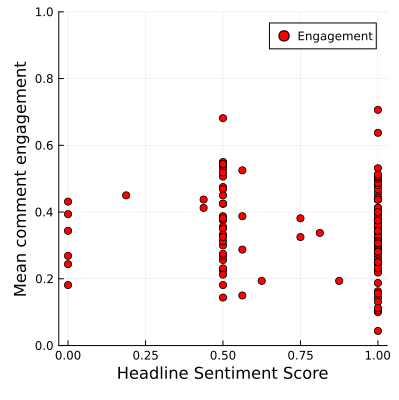

In [34]:

scatter(joined_df[!, :headline_sentiment_score], joined_df[!, :engagement_score_mean],
    xlabel="Headline Sentiment Score", ylabel="Mean comment engagement",
    #title="Headline Sentiment Score vs. Mean Comment Engagement",
    label="Engagement",
    color=:red,
    size=(400, 400),
    legend=true)
ylims!(0.0, 1.0)

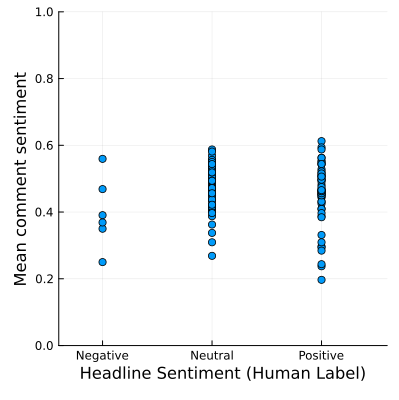

In [35]:

size(joined_df)

scatter(joined_df[!, :headline_sentiment_human], joined_df[!, :sentiment_score_mean],
    xlabel="Headline Sentiment (Human Label)", ylabel="Mean comment sentiment",
    #title="Headline Sentiment Score vs. Mean Comment Sentiment",#
    legend=false,
    size=(400, 400),
    )

xticks!([0.0, 0.5, 1.0], ["Negative", "Neutral", "Positive"])
#scatter!(hsh, ssm,)
ylims!(0.0, 1.0)
xlims!(-0.2, 1.3)


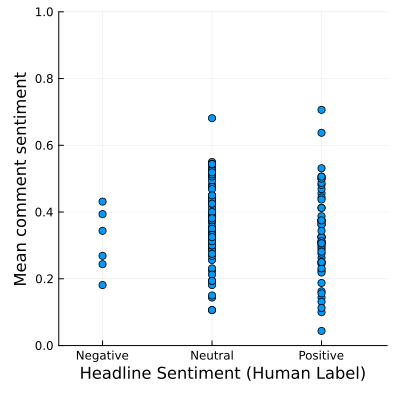

In [36]:

size(joined_df)

scatter(joined_df[!, :headline_sentiment_human], joined_df[!, :engagement_score_mean],
    xlabel="Headline Sentiment (Human Label)", ylabel="Mean comment sentiment",
    #title="Headline Sentiment Score vs. Mean Comment Sentiment",#
    legend=false,
    size=(400, 400),
    )

xticks!([0.0, 0.5, 1.0], ["Negative", "Neutral", "Positive"])
#scatter!(hsh, ssm,)
ylims!(0.0, 1.0)
xlims!(-0.2, 1.3)


In [39]:
@show size(first_engagement_scores)

size(first_engagement_scores) = (1, 123)


(1, 123)

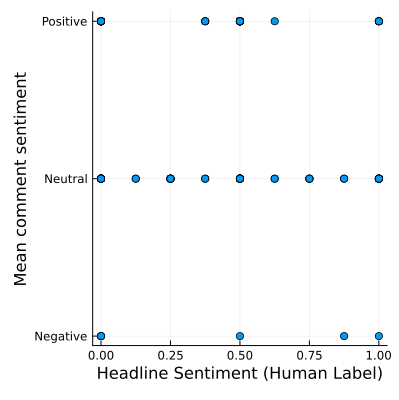

In [40]:

size(joined_df)

scatter(reshape(first_engagement_scores,:), joined_df[!, :headline_sentiment_human],
    xlabel="Headline Sentiment (Human Label)", ylabel="Mean comment sentiment",
    #title="Headline Sentiment Score vs. Mean Comment Sentiment",#
    legend=false,
    size=(400, 400),
    )

yticks!([0.0, 0.5, 1.0], ["Negative", "Neutral", "Positive"])
#scatter!(hsh, ssm,)
#ylims!(0.0, 1.0)
#xlims!(-0.2, 1.3)


### Prediction

Train set size: (1, 98) Validation set size: (1, 25)


Train loss = 0.014750659
Validation loss = 0.020535355
Mean: 0.3559527


Tuple{Float32, Float32}[(0.3125, 0.3573029) (0.525, 0.2708984) (0.23125

, 0.3573029) (0.35625, 0.3650118) (0.375, 0.3573029) (0.35, 0.3650118) (0.15625, 0.3573029) (0.10625, 0.3573029) (0.54375, 0.3650118) (0.10625, 0.3573029) (0.45, 0.3650118) (0.33125, 0.3650118) (0.25, 0.3573029) (0.34375, 0.3573029) (0.1125, 0.3573029) (0.50625, 0.3573029) (0.325, 0.3650118) (0.19375, 0.34057388) (0.4, 0.3573029) (0.38125, 0.3650118) (0.50625, 0.3573029) (0.5125, 0.3573029) (0.54375, 0.3650118) (0.30625, 0.3573029) (0.51875, 0.3650118)]

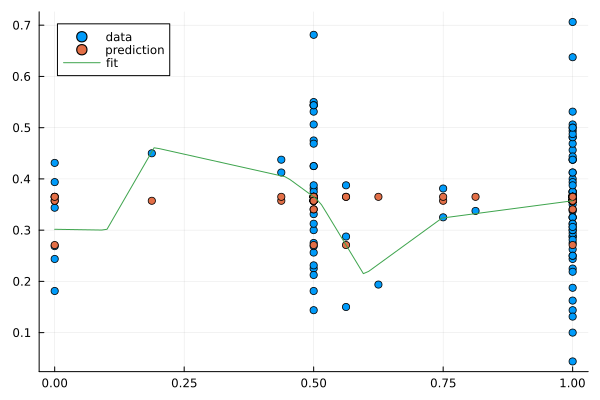

In [16]:

# Simple 2-layer MLP for regression with flux.jl

# Load packages
using Flux
using Statistics
using BSON: @save, @load #BSON is the Julia equivalent of pickle

# Define data as copy of the hss and ssm arrays as x and y
X = Float32.(reshape(hss, 1, :))
y = Float32.(reshape(ssm, 1, :))
y = Float32.(reshape(esm, 1, :))

# Define the network architecture
model = Chain(
  Dense(1, 10, relu),
  Dense(10, 10, relu),
  Dense(10, 1)
)


# Define the loss function (mean squared error for regression)
loss(x, y) = Flux.mse(model(x), y)

#split x and y into training and validation sets
split_ratio = 0.8
X_train, X_val = X[:, 1:round(Int, split_ratio*size(X, 2))], X[:, round(Int, split_ratio*size(X, 2))+1:end]
y_train, y_val = y[:, 1:round(Int, split_ratio*size(y, 2))], y[:, round(Int, split_ratio*size(y, 2))+1:end]
println("Train set size: $(size(X_train)) Validation set size: $(size(X_val))")
train_data = (X_train, y_train)
val_data = (X_val, y_val)
train_dataloader = Flux.Data.DataLoader(train_data, batchsize=16, shuffle=true)
val_dataloader = Flux.Data.DataLoader(val_data, batchsize=8, shuffle=false)

# Define the optimization method
opt = ADAM(0.001)

# Train the network
epochs = 10000
for epoch in 1:epochs
  for batch in train_dataloader
    Flux.train!(loss, Flux.params(model), [batch,], opt,)
  end
end
# Evaluate/validate the model by printing loss plotting x, y_true and y_pred

println("Train loss = $(loss(X_train, y_train))")
println("Validation loss = $(loss(X_val, y_val))")

y_pred = model(X_val)
println("Mean: $(mean(y_pred))")
println(collect(zip(y_val, y_pred)))

# Flatten array of (1, 123) size
scatter(reshape(X_train, :),reshape(y_train, :), label="data")
scatter!(reshape(X_train, :), reshape(y_pred, :), label="prediction")
x_eval = range(minimum(X_train), stop=maximum(X_train), length=100)
y_eval = reshape(model(reshape(x_eval, 1, :)), :)
plot!(x_eval, y_eval, label="fit")


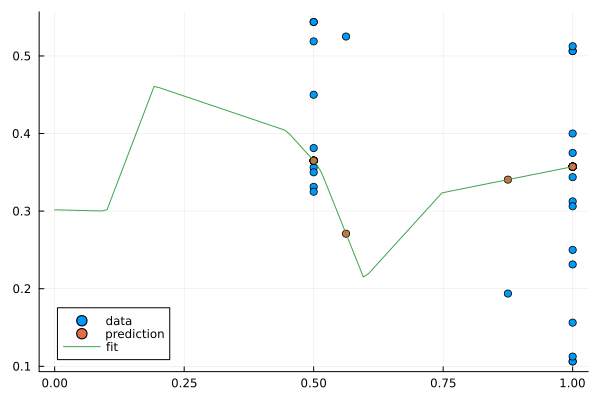

In [17]:
scatter(reshape(X_val, :),reshape(y_val, :), label="data")
scatter!(reshape(X_val, :), reshape(y_pred, :), label="prediction")
y_eval = reshape(model(reshape(x_eval, 1, :)), :)
plot!(x_eval, y_eval, label="fit")


In [18]:
using GaussianProcesses

# Define the mean and kernel functions
meanf = MeanZero()
kernf = SE(0.0, 0.0)  # Squared Exponential kernel

# Define the Gaussian Process
gp = GP(meanf, kernf)


# Fit the GP model
optimize!(gp, X_train, y_train )

# Predict the mean and variance of the test data
y_pred, y_var = predict_y(gp, X_test)

# Calculate the RMSE
rmse = sqrt(sum((y_pred - y_test).^2) / length(y_test)) 
println("RMSE: ", rmse)

# Plot the results
plot(X_test, y_test, label="True")
plot!(X_test, y_pred, ribbon=sqrt.(y_var), label="Predicted")


MethodError: MethodError: no method matching GP(::MeanZero, ::SEIso{Float64})